<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/6_Low_Volatility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Low Volatility

In this notebook we do factor analysis on simple volatility factors.



## Load libraries and authenticate

In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = FALSE, extra_libraries = c('lubridate', "RcppRoll","QuantTools"), extra_dependencies = c())

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



-- R CMD build -----------------------------------------------------------------
* checking for file /tmp/RtmpHJCRwG/remotesda159284fa/RWLab-rwRtools-1924b0b/DESCRIPTION ... OK
* preparing rwRtools:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted LazyData from DESCRIPTION
  NB: this package now depends on R (>= 3.5.0)
  serialize/load version 3 cannot be read in older versions of R.
  File(s) containing such objects:
    rwRtools/R/sysdata.rda
* building rwRtools_0.1.33.tar.gz



In [2]:
# snippet: rw data auth v.0.1
rwlab_data_auth()

Authorization successful!

## Load Coinmetrics daily data

In [3]:
# snippet: rw crypto quickstart v.0.1
quicksetup(pod = "Crypto", path = ".")
prices %>% 
  head()


Set default bucket name to 'crypto_research_pod'



Attempting download of  coinmetrics.csv ...
Transferring coinmetrics.csv ... data is 2.4 Mb please be patient...


i Downloading coinmetrics.csv

v Saved coinmetrics.csv to ./coinmetrics.csv  ( 2.4 Mb )





coinmetrics.csv successfully transferred


Rows: 49183 Columns: 4
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (1): ticker
dbl  (2): price_usd, market_cap
date (1): date

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


prices data object transferred and loaded as data.frame to Global Env


ticker,date,price_usd,market_cap
<chr>,<date>,<dbl>,<dbl>
1INCH,2020-12-26,1.6193281,2428992153
1INCH,2020-12-27,1.0723502,1608525301
1INCH,2020-12-28,1.1046742,1657011227
1INCH,2020-12-29,0.8937904,1340685538
1INCH,2020-12-30,1.1013066,1651959828
1INCH,2020-12-31,1.3652374,2047856106


# Creating research universe

See Notebook 1 for details on how we construct the universe.

In [4]:
# snippet: rw crypto flag universe consituents v0.1
create_universe <- function(prices, n=10, min_constituents = 10) {
  # snippet: rw crypto remove stablecoins v0.2
  # Remove stablecoins from data set
  prices <- prices %>% 
    filter(!ticker %in% c('BUSD','DAI','GUSD','HUSD','PAX','SAI','TUSD','USDC','USDK','USDT','USDT_ETH','USDT_OMNI','USDT_TRX', 'XAUT')) 
  # snippet: rw crypto remove duplicates v0.1
  # Remove duplicate protocol coins from data set
  prices <- prices %>% 
    filter(!ticker %in% c('BNB_ETH','LEO_EOS','RENBTC', 'WNXM', 'WETH', 'WBTC'))

  # Get first date where we have min_constituents
  start_date <- prices %>%
    group_by(date) %>%
    summarise(count = n()) %>%
    filter(count >= min_constituents) %>%
    summarise(mindate = min(date)) %>%
    pull(mindate)

  # Flag universe consitutents
  # For a given ticker/date observation, set is_index to TRUE if:
  #    - the asset was in the top 10 coins by market cap the day before
  #    - the date is on or after the date when we have min_consituents assets in our dataset
  prices %>%
    group_by(date) %>%
    mutate(cap_rank = row_number(desc(market_cap))) %>%
    arrange(date) %>%
    group_by(ticker) %>%
    mutate(is_index = lag(cap_rank) <= n & date >= '2015-04-01') %>%
    na.omit() %>%
    ungroup()
}

In [5]:
universe <- create_universe(prices, n = 20, min_constituents = 20)
universe %>%
  head()

ticker,date,price_usd,market_cap,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<int>,<lgl>
BTC,2010-07-18,0.08584000,295959.2,1,FALSE
BTC,2010-07-19,0.08080000,279285.2,1,FALSE
BTC,2010-07-20,0.07473573,259000.4,1,FALSE
BTC,2010-07-21,0.07919286,275266.5,1,FALSE
BTC,2010-07-22,0.05846976,203749.6,1,FALSE
BTC,2010-07-23,0.06059287,211735.7,1,FALSE


In [6]:
universe%>%
head()

ticker,date,price_usd,market_cap,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<int>,<lgl>
BTC,2010-07-18,0.08584000,295959.2,1,FALSE
BTC,2010-07-19,0.08080000,279285.2,1,FALSE
BTC,2010-07-20,0.07473573,259000.4,1,FALSE
BTC,2010-07-21,0.07919286,275266.5,1,FALSE
BTC,2010-07-22,0.05846976,203749.6,1,FALSE
BTC,2010-07-23,0.06059287,211735.7,1,FALSE


# Create Low Volatility Feature and Forward Returns

Calculate 20 day momentum factor,120 day low volatility and next day returns.

In [7]:
returns <- universe %>%
  group_by(ticker) %>%
  arrange(date) %>%
  # Calculate 20d momentum feature
  mutate(momo20 = price_usd / lag(price_usd, n = 20) - 1,
         lagmomo20 = lag(momo20),
         volatility120 = roll_sdr(price_usd,  120,align = c("right")),
         lagvolatility120 = lag(volatility120),
         ) %>% 
  # Calculate next day returns
  mutate(fwd_log_return = log(lead(price_usd) / price_usd),
         fwd_simple_return = lead(price_usd) / price_usd - 1) %>%
  na.omit() %>%
  ungroup()

  returns %>% head(10)

ticker,date,price_usd,market_cap,cap_rank,is_index,momo20,lagmomo20,volatility120,lagvolatility120,fwd_log_return,fwd_simple_return
<chr>,<date>,<dbl>,<dbl>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BTC,2010-11-15,0.2684646,1235997,1,FALSE,0.7779110,1.0057713,0.06843617,0.06664307,-0.1766184949,-0.1619005372
BTC,2010-11-16,0.2250000,1038105,1,FALSE,0.1987214,0.7779110,0.06937349,0.06843617,0.0725866054,0.0752859277
BTC,2010-11-17,0.2419393,1119248,1,FALSE,0.3976853,0.1987214,0.07052726,0.06937349,0.1062391845,0.1120878388
BTC,2010-11-18,0.2690578,1248159,1,FALSE,0.4160936,0.3976853,0.07213193,0.07052726,0.0337375434,0.0343131087
BTC,2010-11-19,0.2782900,1293074,1,FALSE,0.4082751,0.4160936,0.07375988,0.07213193,0.0168395738,0.0169821587
BTC,2010-11-20,0.2830160,1316675,1,FALSE,0.4702128,0.4082751,0.07541055,0.07375988,-0.0223887377,-0.0221399699
BTC,2010-11-21,0.2767500,1289461,1,FALSE,0.4226959,0.4702128,0.07682983,0.07541055,0.0293746087,0.0298102981
BTC,2010-11-22,0.2850000,1330223,1,FALSE,0.4705882,0.4226959,0.07830507,0.07682983,-0.0072189767,-0.0071929825
BTC,2010-11-23,0.2829500,1322636,1,FALSE,0.4653030,0.4705882,0.07970184,0.07830507,-0.0001564483,-0.0001564361


# Analyzing The 20 day low volatility
 factor

Each day:
 - Rank each coin by its 120 day volatility 
 - Group by rank
 - Plot the mean next day log return for each rank. 

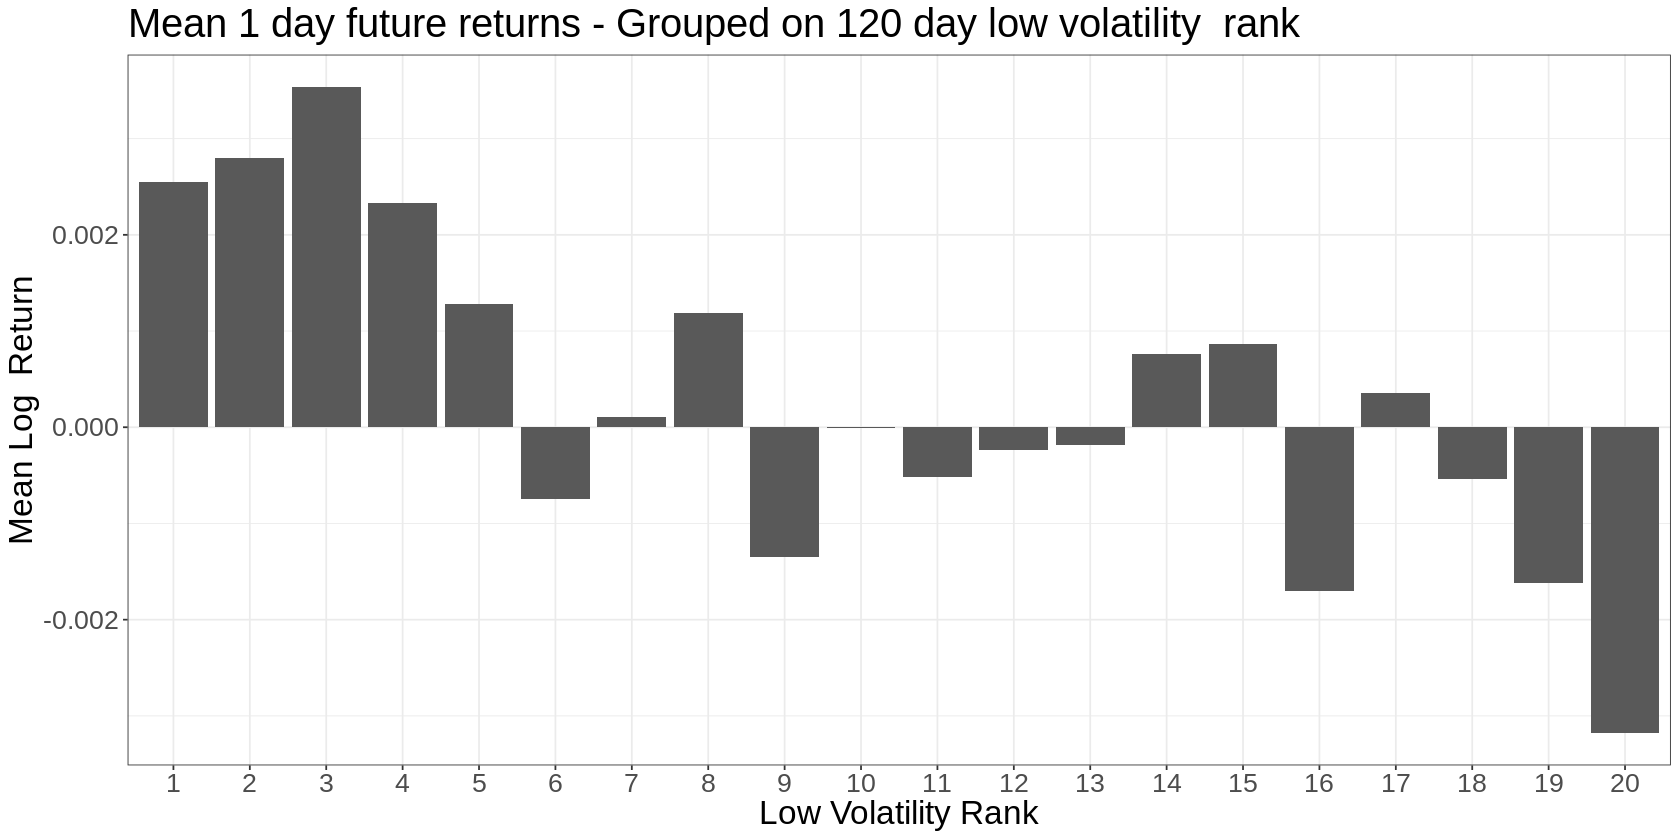

In [8]:
returns %>%
  filter(is_index == TRUE) %>%
  group_by(date) %>%
  mutate(rank = factor(row_number(volatility120))) %>%
  group_by(rank) %>%
  summarise(mean_fwd_log_ret = mean(fwd_log_return)) %>%
  ggplot(aes(x=rank, y=mean_fwd_log_ret)) + 
  geom_bar(stat='identity') + 
  labs(
    title = 'Mean 1 day future returns - Grouped on 120 day low volatility  rank',
    x = 'Low Volatility Rank',
    y = 'Mean Log  Return'
  )

Let's plot this separately for each year in our sample.

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


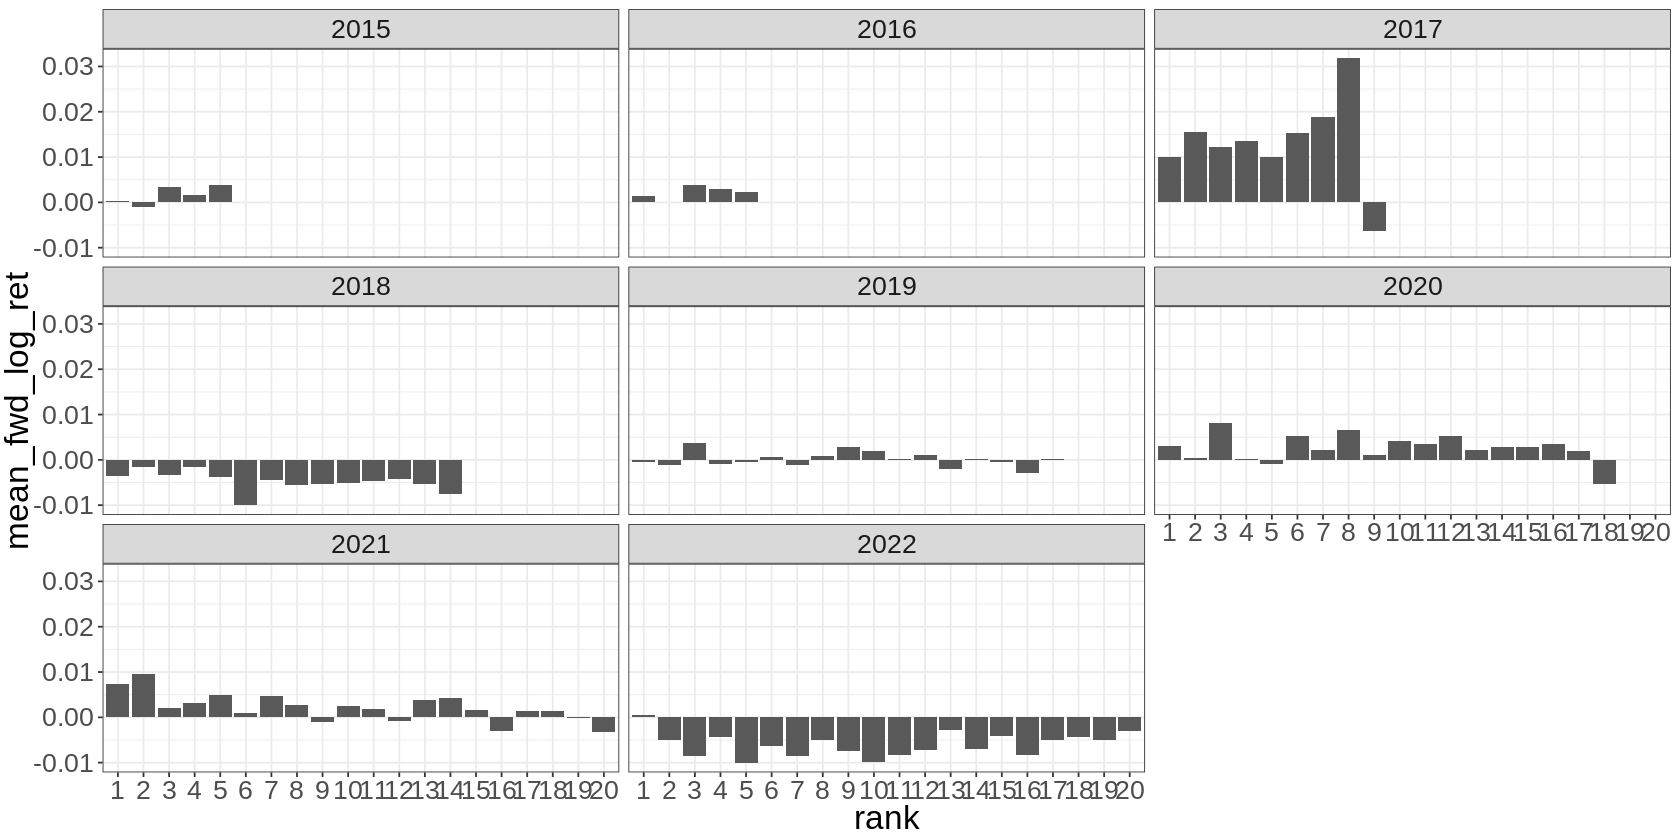

In [9]:
returns %>%
  mutate(year = factor(year(date))) %>%
  filter(is_index == TRUE) %>%
  group_by(date) %>%
  mutate(rank = factor(row_number(volatility120))) %>%
  group_by(year, rank) %>%
  summarise(mean_fwd_log_ret = mean(fwd_log_return)) %>%
  ggplot(aes(x=rank, y = mean_fwd_log_ret))  +
    geom_bar(stat='identity') +
    facet_wrap(~year)

To make this easier to interpret, let's demean our return target - so we're plotting the relative outperformance rather than absolute outperformance.

In [10]:
demeaned_returns <- returns %>%
  filter(is_index) %>%
  group_by(date) %>%
  mutate(
    demeaned_fwd_log_return = fwd_log_return - mean(fwd_log_return),
    demeaned_fwd_simple_return = fwd_simple_return - mean(fwd_simple_return) 
  )

demeaned_returns %>% tail(10)

ticker,date,price_usd,market_cap,cap_rank,is_index,momo20,lagmomo20,volatility120,lagvolatility120,fwd_log_return,fwd_simple_return,demeaned_fwd_log_return,demeaned_fwd_simple_return
<chr>,<date>,<dbl>,<dbl>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FTT,2022-05-31,2.901579e+01,9630785202,6,TRUE,-0.016540680,-0.11800290,6.432663e+00,6.342693e+00,-0.0744831479,-0.0717768835,-0.012514378,-0.012165303
HT,2022-05-31,7.162895e+00,3581447555,12,TRUE,-0.027663502,-0.12731190,9.432949e-01,9.289514e-01,-0.0143658658,-0.0142631692,0.047602904,0.045348412
LINK,2022-05-31,7.637923e+00,7637922918,8,TRUE,0.108769638,-0.13072471,3.464582e+00,3.444432e+00,-0.0976540931,-0.0930374259,-0.035685323,-0.033425845
LTC,2022-05-31,6.865651e+01,4833979040,10,TRUE,0.037994320,-0.13743462,2.008343e+01,1.981717e+01,-0.0876535369,-0.0839217910,-0.025684767,-0.024310210
MKR,2022-05-31,1.321858e+03,1292289481,16,TRUE,0.179938811,0.13041722,3.236459e+02,3.221937e+02,-0.0881614114,-0.0843869256,-0.026192641,-0.024775345
PAXG,2022-05-31,1.837413e+03,612963438,19,TRUE,-0.005886664,0.01069527,5.532894e+01,5.576559e+01,0.0069729514,0.0069973190,0.068941721,0.066608900
SNX,2022-05-31,3.142974e+00,841651228,17,TRUE,0.273515656,0.02062754,1.208914e+00,1.206436e+00,-0.0904270577,-0.0864590327,-0.028458288,-0.026847452
TRX,2022-05-31,8.350335e-02,8350335492,7,TRUE,0.123978630,0.08580619,7.342165e-03,7.219979e-03,0.0001517352,0.0001517467,0.062120505,0.059763328
UNI,2022-05-31,5.707797e+00,5707796751,9,TRUE,0.176734218,-0.06950393,2.104151e+00,2.102149e+00,-0.0992629487,-0.0944954245,-0.037294179,-0.034883844


If we've done this right, then the sum of the demeaned returns for all dates should be zero.

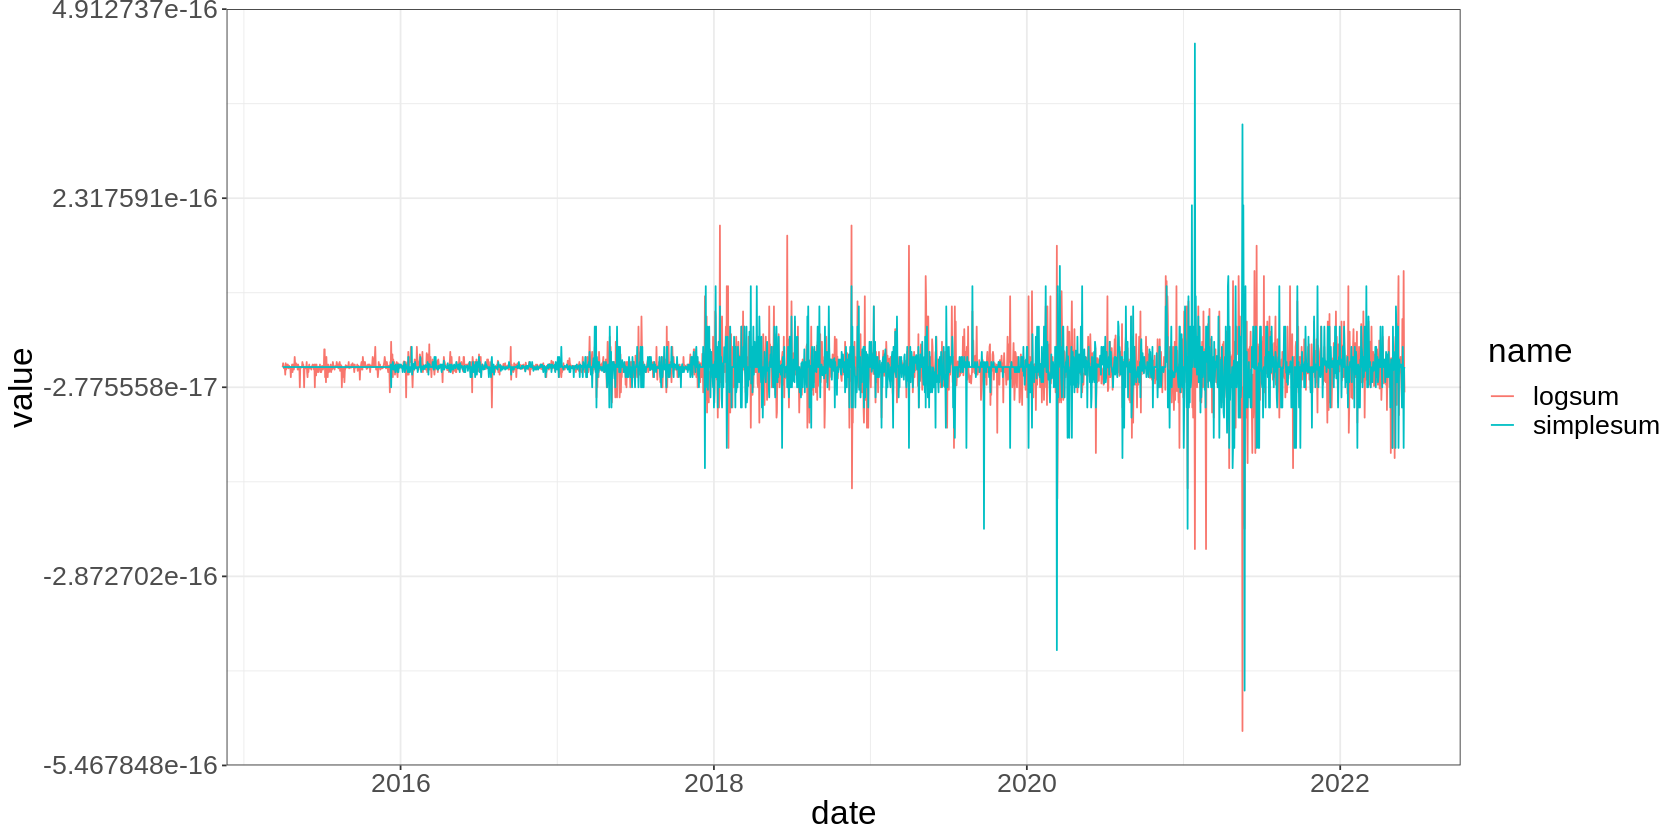

In [11]:
demeaned_returns %>%
  group_by(date) %>%
  summarise(
    logsum = sum(demeaned_fwd_log_return),
    simplesum = sum(demeaned_fwd_simple_return)
  ) %>%
  pivot_longer(-date) %>%
  ggplot(aes(x=date, y=value, color = name)) + geom_line()

Just rounding stuff...

Now let's plot de-meaned log return for each rank for each year

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


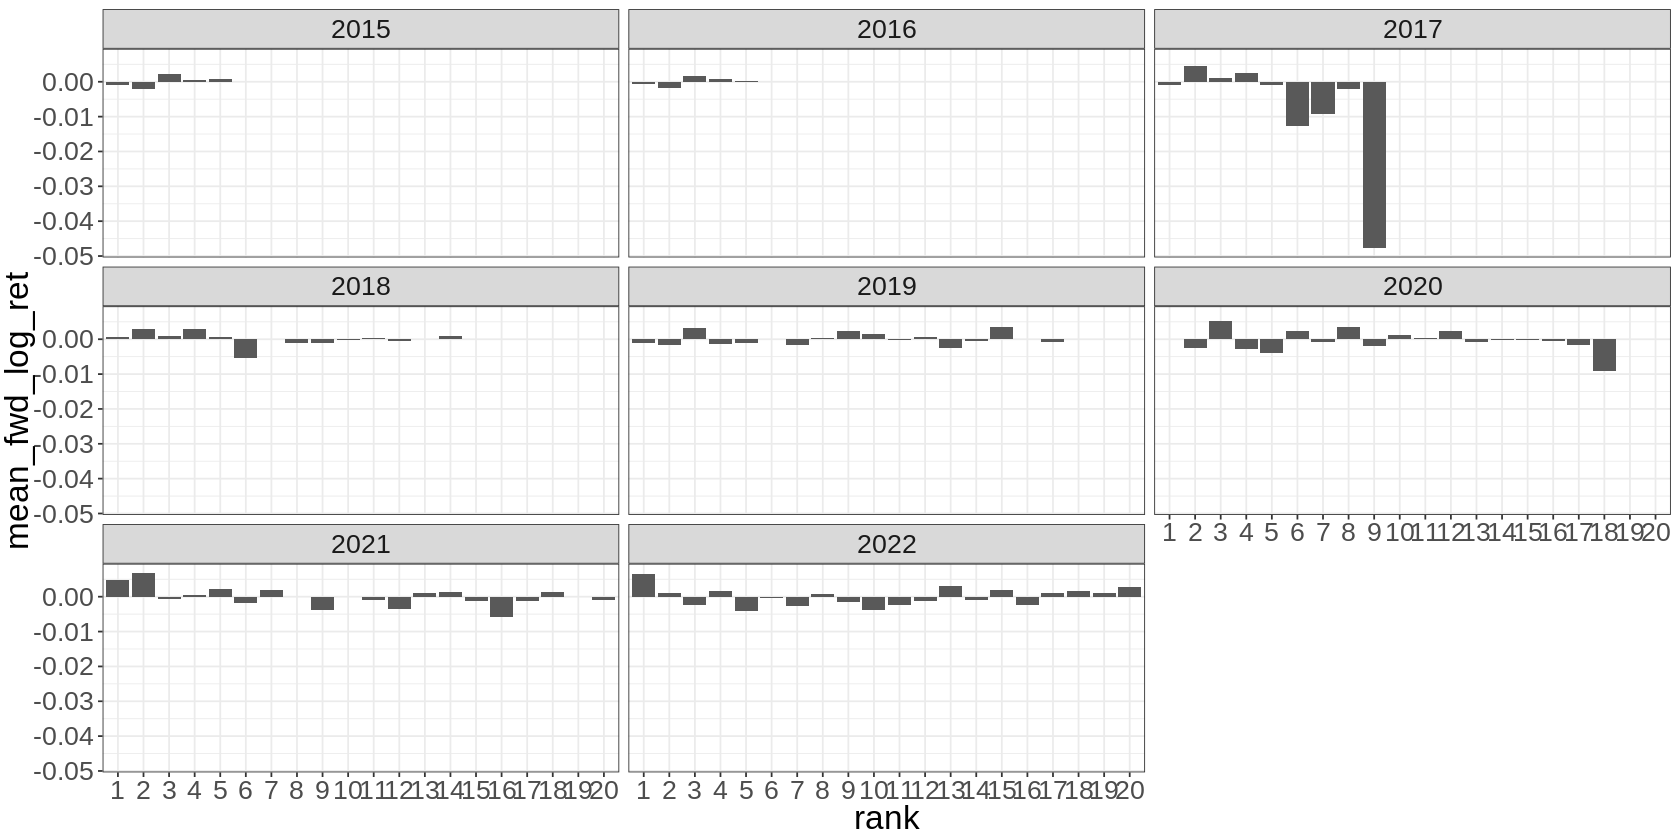

In [12]:
demeaned_returns %>%
  mutate(year = factor(year(date))) %>%
  filter(is_index == TRUE) %>%
  group_by(date) %>%
  mutate(rank = factor(row_number(volatility120))) %>%
  group_by(year, rank) %>%
  summarise(mean_fwd_log_ret = mean(demeaned_fwd_log_return)) %>%
  ggplot(aes(x=rank, y = mean_fwd_log_ret))  +
    geom_bar(stat='identity') +
    facet_wrap(~year)

Let's see if low volatility has any issues with lags


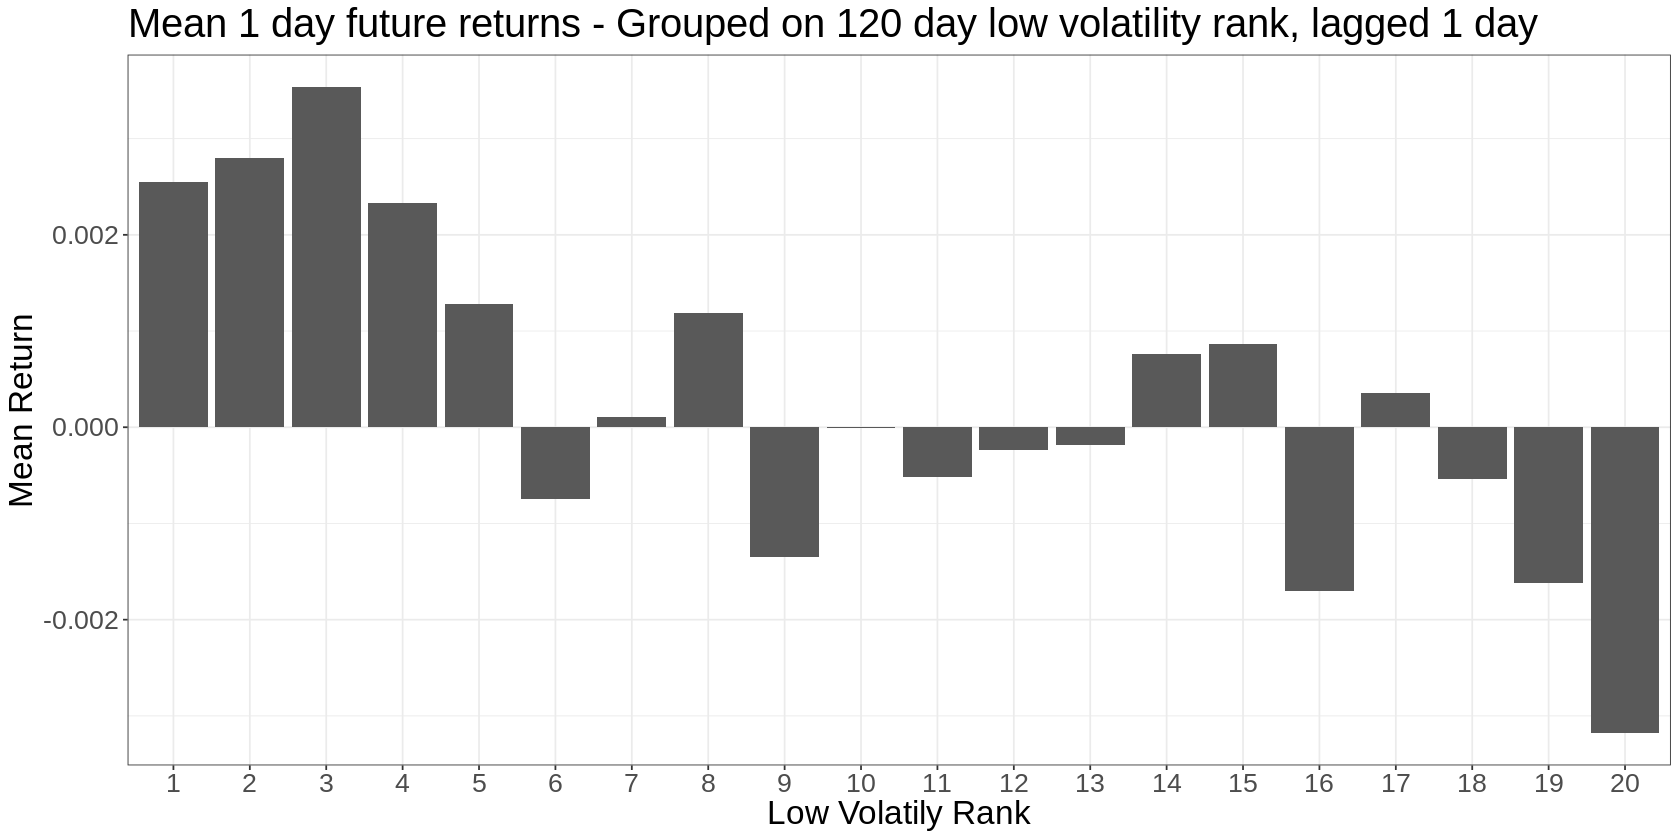

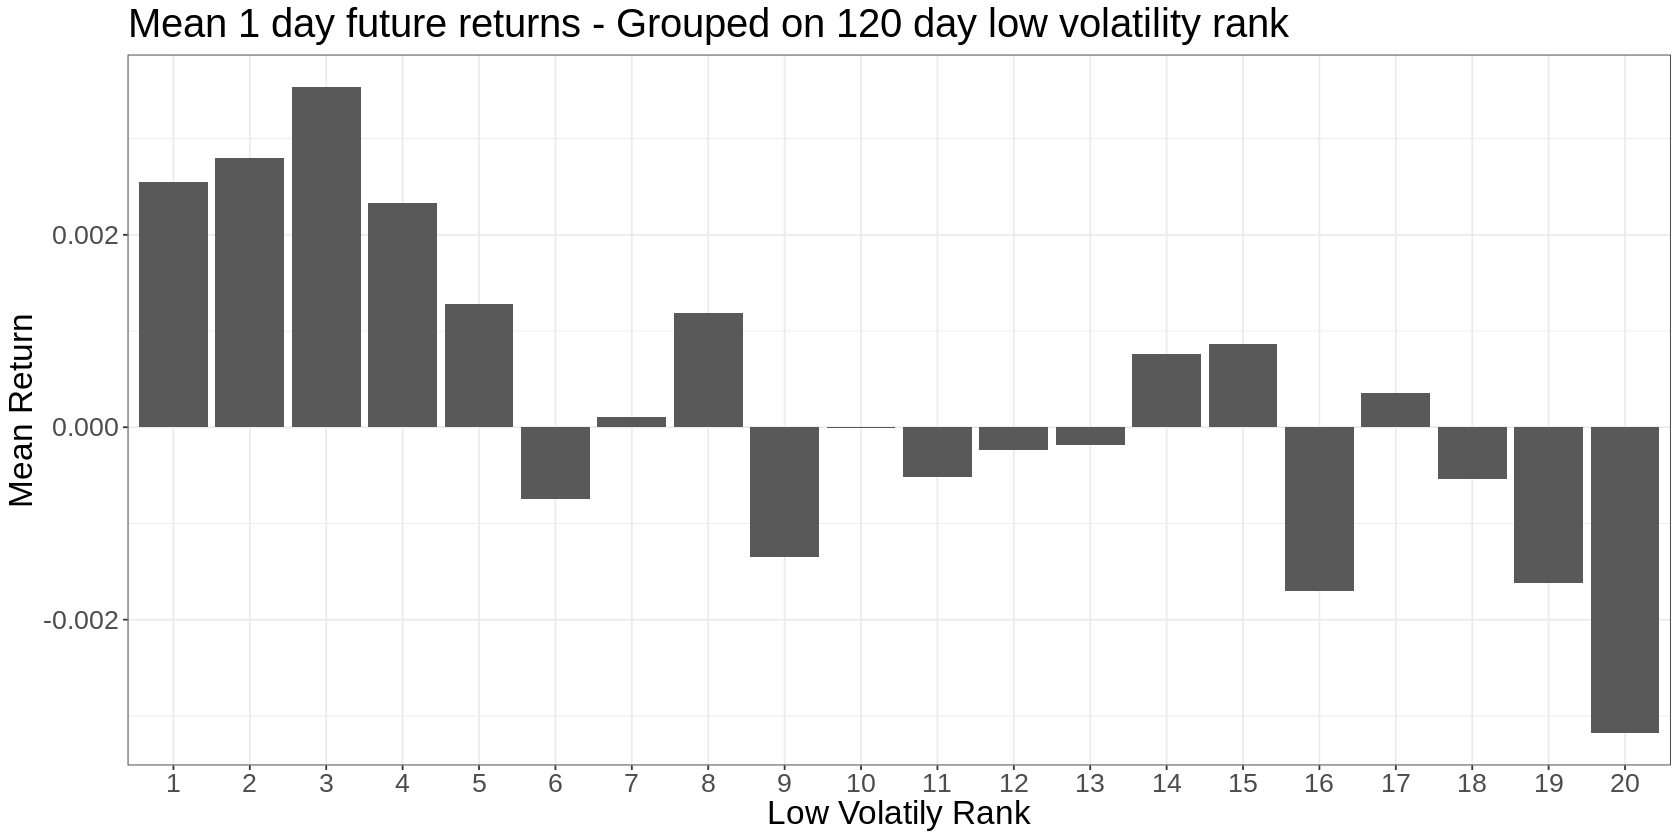

In [13]:
returns %>%
  filter(is_index == TRUE) %>%
  group_by(date) %>%
  mutate(lagrank = factor(row_number(volatility120))) %>%
  group_by(lagrank) %>%
  summarise(mean_fwd_log_ret = mean(fwd_log_return)) %>%
  ggplot(aes(x=lagrank, y=mean_fwd_log_ret)) + 
  geom_bar(stat='identity') + 
  labs(
    title = 'Mean 1 day future returns - Grouped on 120 day low volatility rank, lagged 1 day',
    x = 'Low Volatily Rank',
    y = 'Mean Return'
  )

  returns %>%
    filter(is_index == TRUE) %>%
    group_by(date) %>%
    mutate(rank = factor(row_number(volatility120))) %>%
    group_by(rank) %>%
    summarise(mean_fwd_log_ret = mean(fwd_log_return)) %>%
    ggplot(aes(x=rank, y=mean_fwd_log_ret)) + 
    geom_bar(stat='identity') + 
    labs(
      title = 'Mean 1 day future returns - Grouped on 120 day low volatility rank',
      x = 'Low Volatily Rank',
      y = 'Mean Return'
    )

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


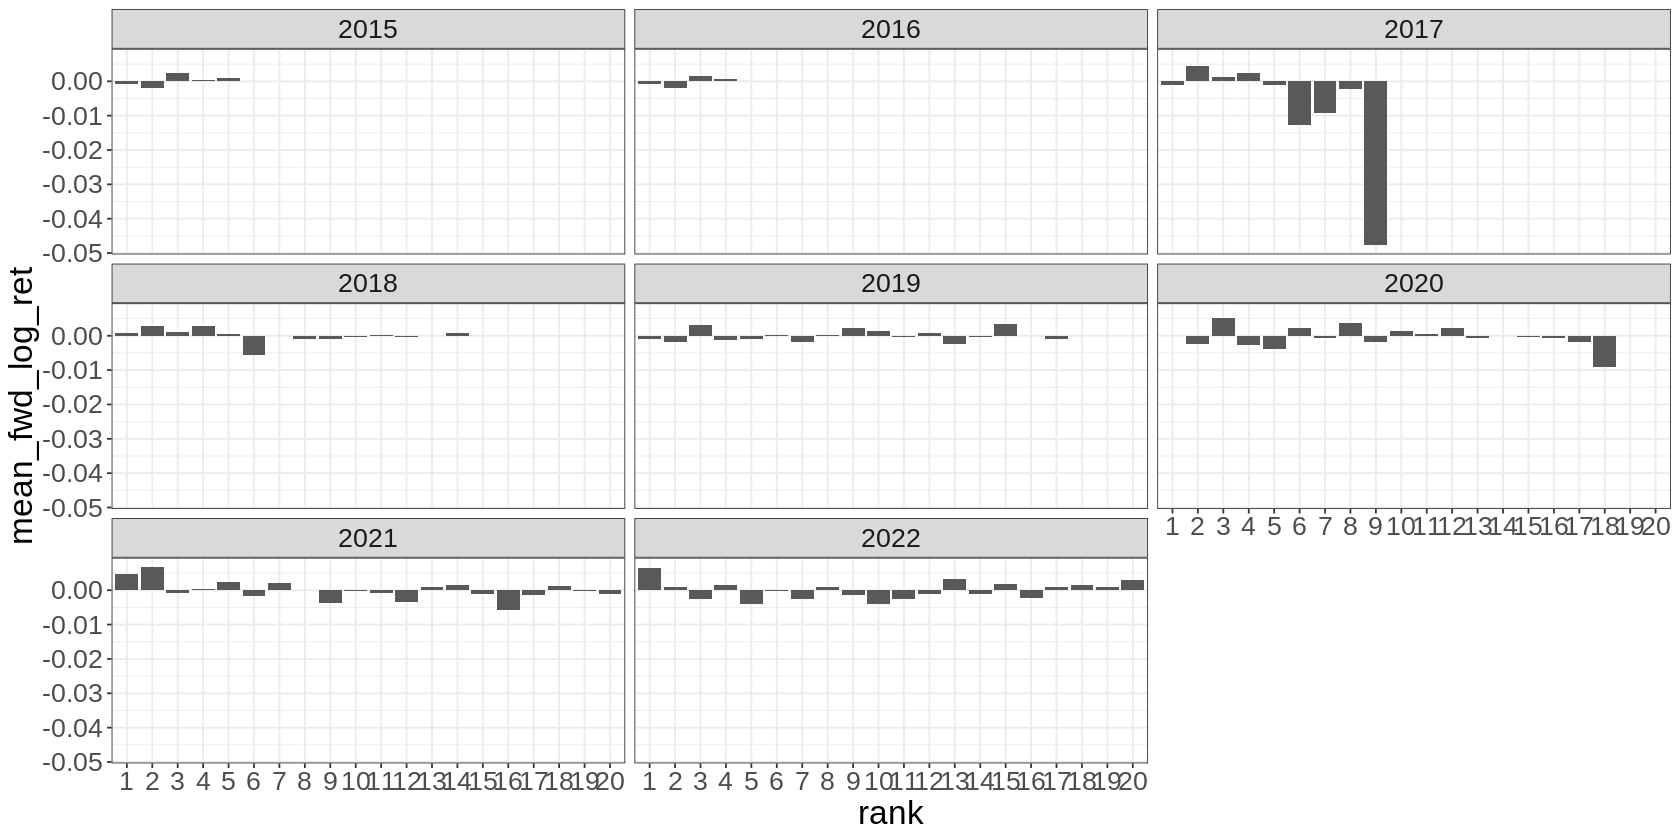

In [14]:
demeaned_returns %>%
  mutate(year = factor(year(date))) %>%
  filter(is_index == TRUE) %>%
  group_by(date) %>%
  mutate(rank = factor(row_number(volatility120))) %>%
  group_by(year, rank) %>%
  summarise(mean_fwd_log_ret = mean(demeaned_fwd_log_return)) %>%
  ggplot(aes(x=rank, y = mean_fwd_log_ret))  +
    geom_bar(stat='identity') +
    facet_wrap(~year)

# Creating a factor time series

Now, we're going to construct a number of factor time series. 

1. Top decile - bottom decile
2. Weight all assets in proportion to rank - mean(rank)
3. Weight all assets in proportion to zscore

We have to inverse our rankings to get them correct 



## 1: Top - Bottom Decile Factor Plot

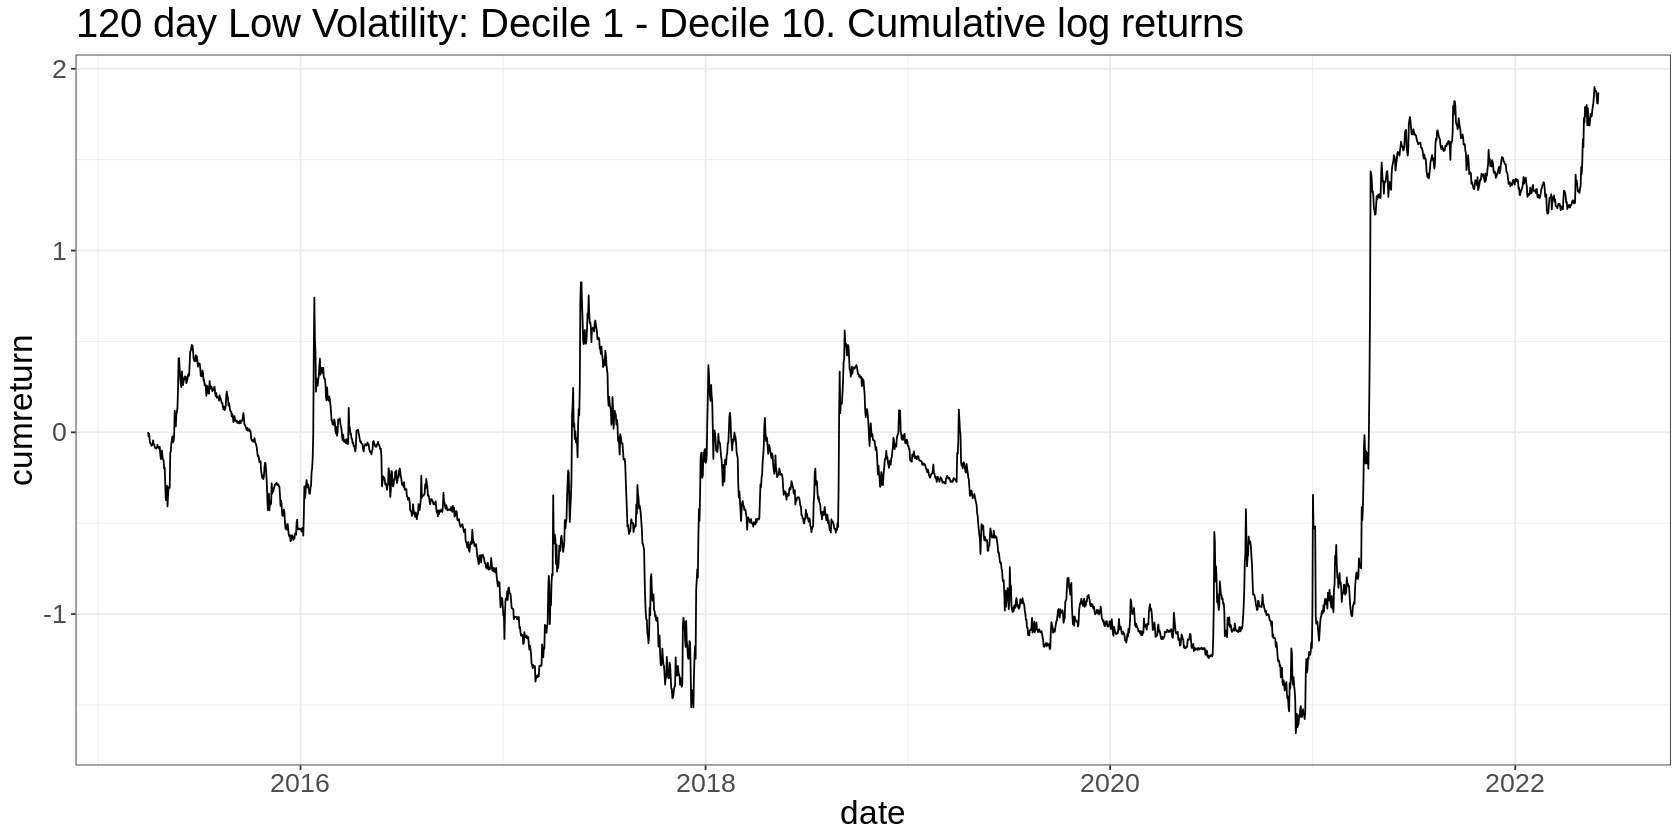

In [15]:
top_ranked <- returns %>% 
  filter(is_index) %>%
  group_by(date) %>%
  mutate(rank = row_number(volatility120*-1)) %>%
  filter(rank == max(rank)) %>%
  select(date, top_return = fwd_simple_return)

bottom_ranked <- returns %>%
  filter(is_index) %>%
  group_by(date) %>%
  mutate(rank = row_number(volatility120*-1)) %>%
  filter(rank == min(rank)) %>%
  select(date, bottom_return = fwd_simple_return)

top_ranked %>%
  inner_join(bottom_ranked, by = 'date') %>%
  mutate(
    factor_return = top_return - bottom_return,
    log_factor_return = log(1+factor_return)
  ) %>%
  ungroup() %>%
  arrange(date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) %>%
  ggplot(aes(x=date, y=cumreturn)) +
    geom_line() +
    ggtitle('120 day Low Volatility: Decile 1 - Decile 10. Cumulative log returns')



##2: Weight all assets in proportion to rank - mean(rank)

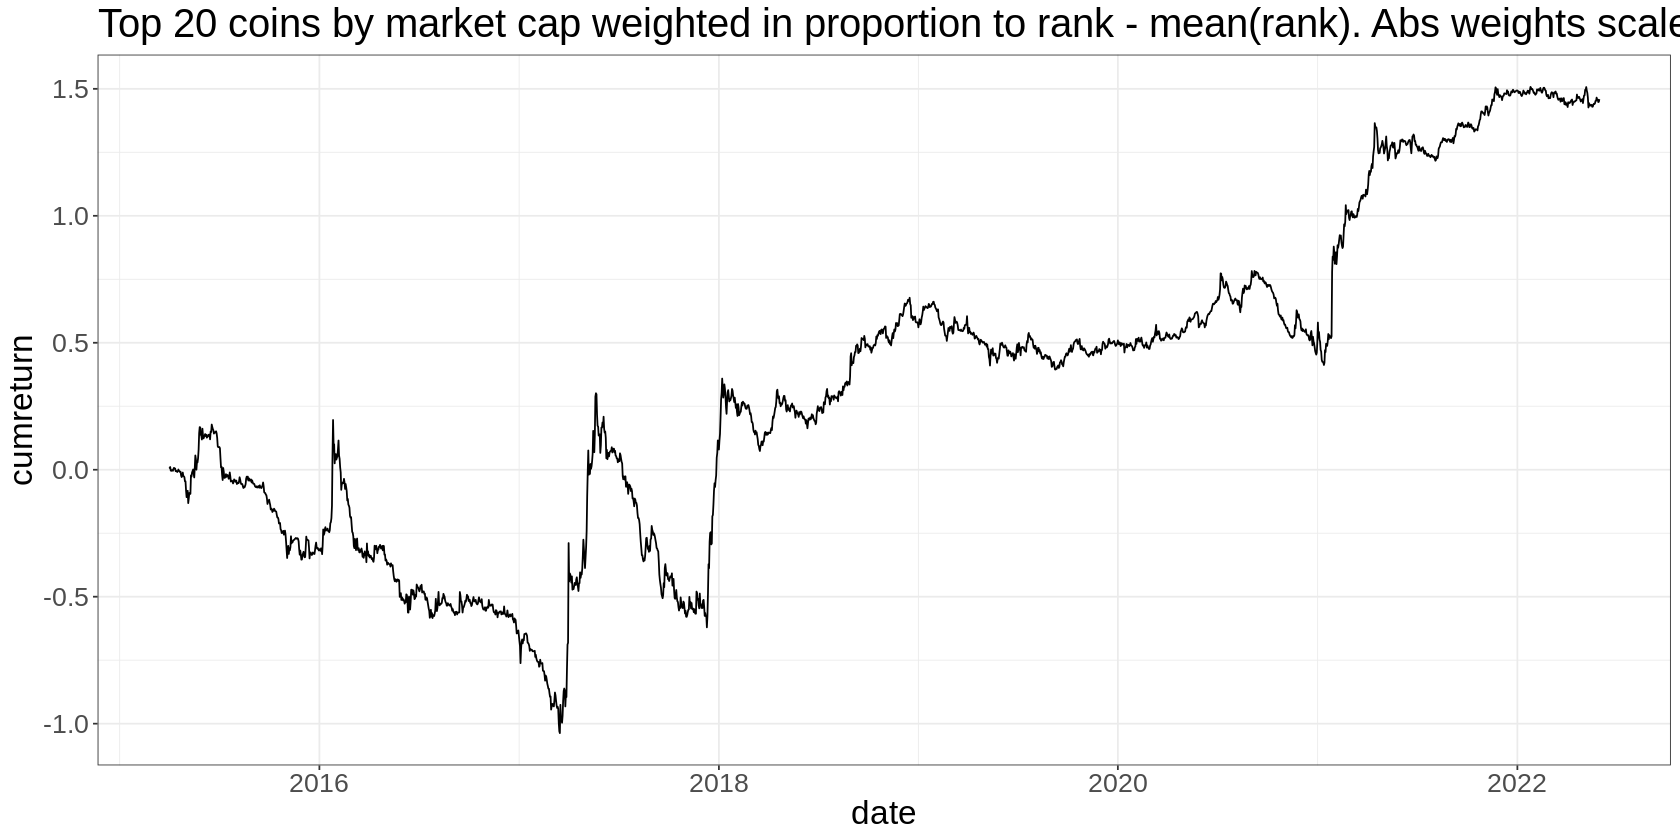

In [16]:
returns %>%
  filter(is_index) %>%
  group_by(date) %>%
  mutate(
    rank = row_number(volatility120*-1),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = fwd_simple_return * scaled_weight
  ) %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  ungroup() %>%
  arrange(date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) %>%
  ggplot(aes(x=date, y=cumreturn)) +
    geom_line() +
    ggtitle('Top 20 coins by market cap weighted in proportion to rank - mean(rank). Abs weights scaled to 1. Cum log returns')

##3: Weight assets in Proprtion to Momentum ZScore

The zscore of an observation is the number of standard deviations above or below the sample mean that an observation sits.

It's a useful way to standardize how different the observations are.

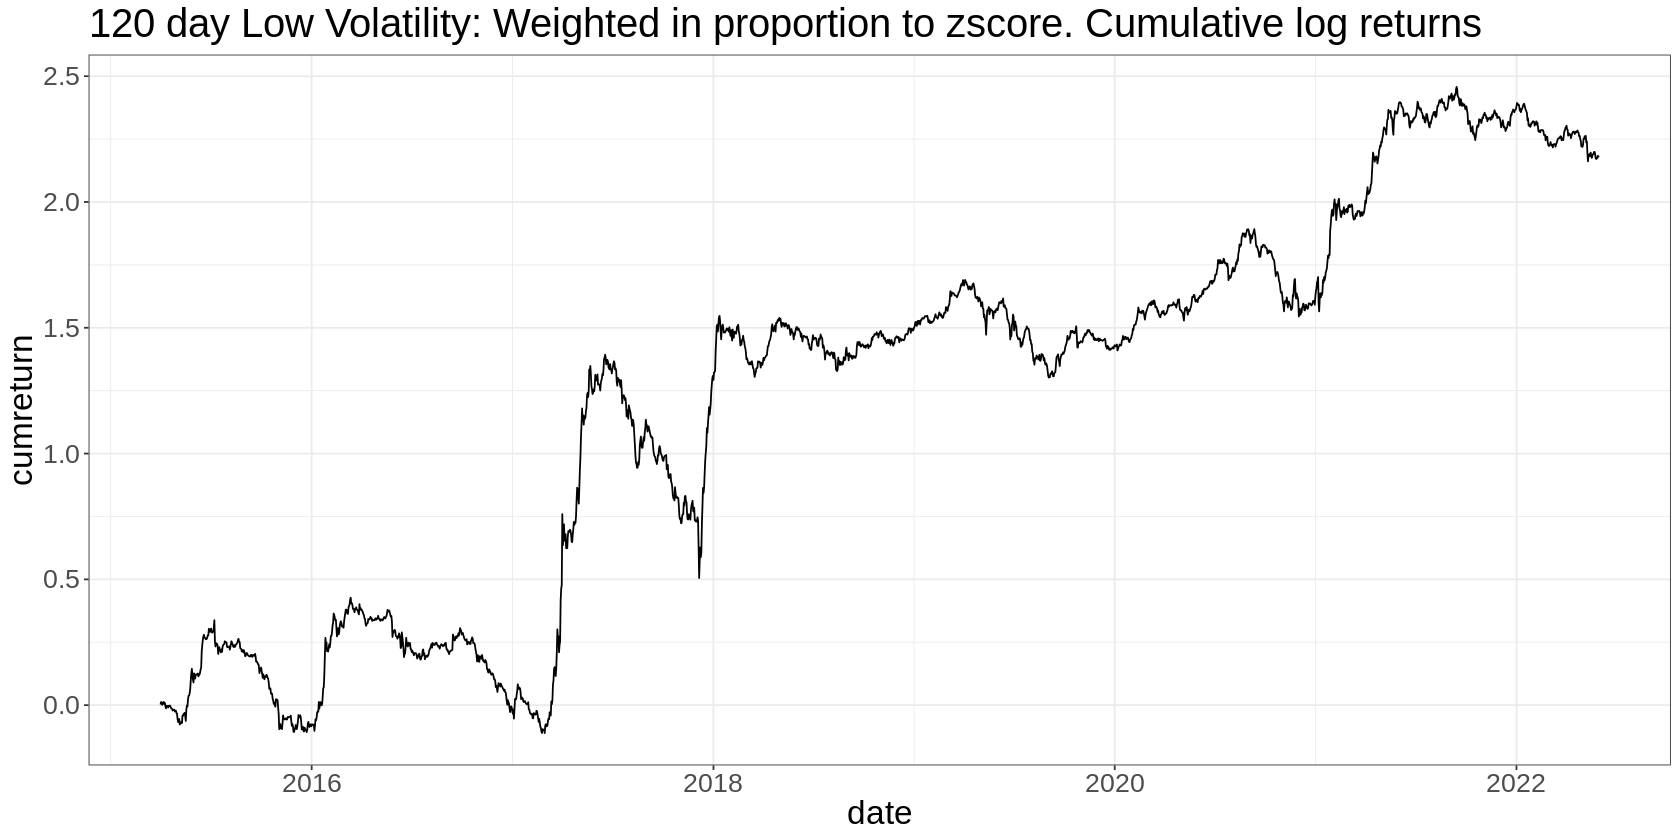

In [17]:
returns %>%
  filter(is_index) %>%
  group_by(date) %>%
  mutate(
    zscore = -(volatility120 - mean(volatility120)) / sd(volatility120),
    scaled_weight = zscore / sum(abs(zscore)),
    weighted_fwd_returns = fwd_simple_return * scaled_weight
  ) %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  ungroup() %>%
  arrange(date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) %>%
  ggplot(aes(x=date, y=cumreturn)) +
    geom_line() +
    ggtitle('120 day Low Volatility: Weighted in proportion to zscore. Cumulative log returns')

What if we max zscore out at 2... 



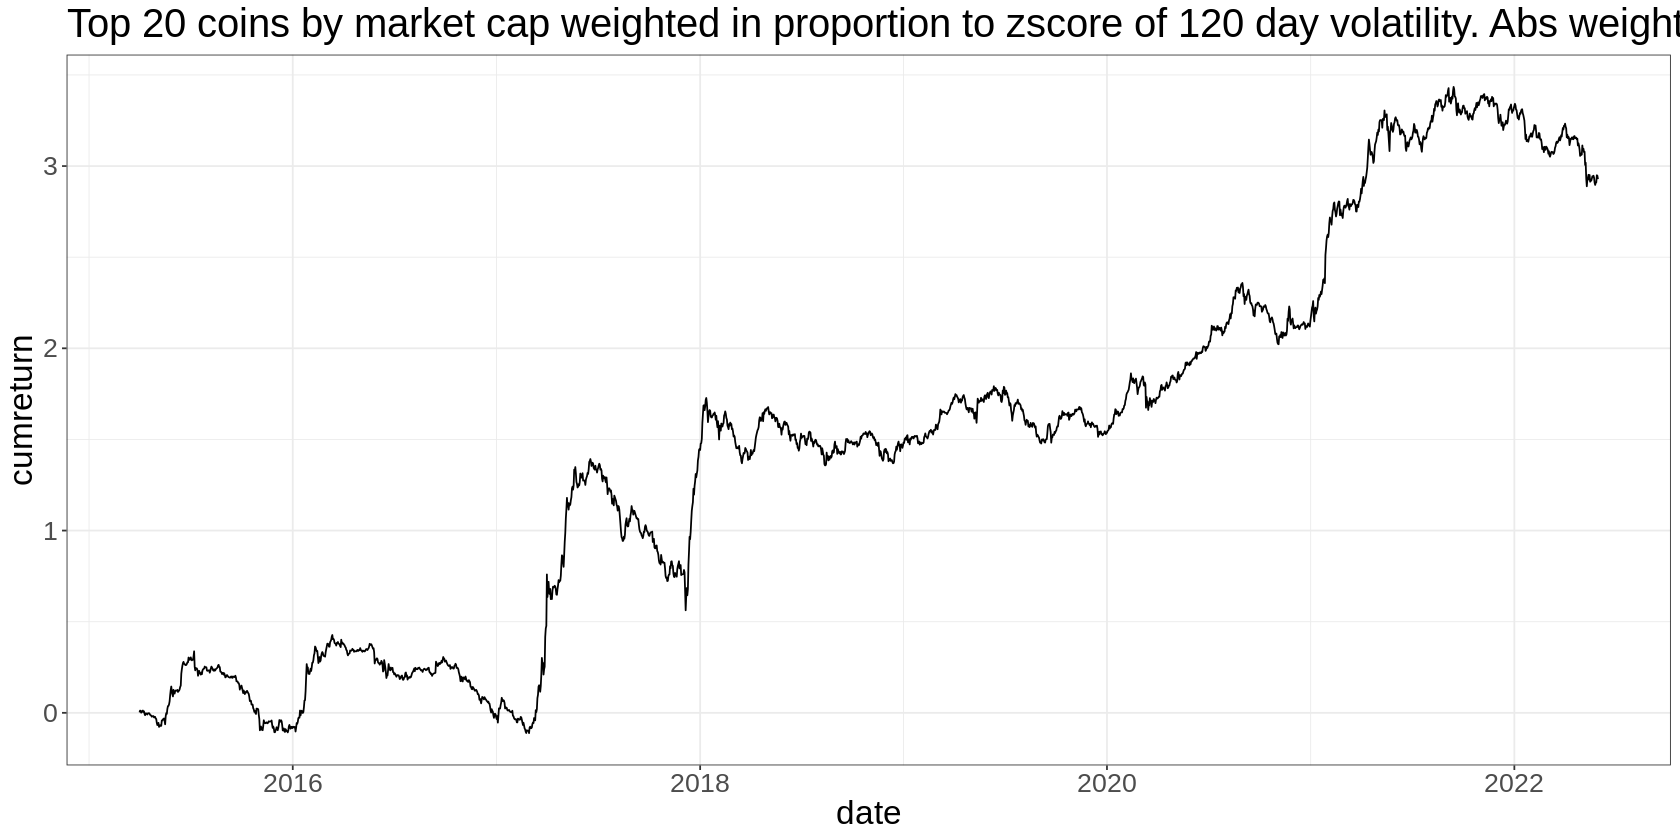

In [18]:
returns %>%
  filter(is_index) %>%
  group_by(date) %>%
  mutate(
    zscore = -(volatility120 - mean(volatility120)) / sd(volatility120),
    weight = case_when(zscore < -2 ~ -2, zscore > 2 ~ 2, TRUE ~ zscore),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = fwd_simple_return * scaled_weight
  ) %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  ungroup() %>%
  arrange(date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) %>%
  ggplot(aes(x=date, y=cumreturn)) +
    geom_line() +
    ggtitle('Top 20 coins by market cap weighted in proportion to zscore of 120 day volatility. Abs weights scaled to 1. Cum log returns')

# Summary

We see a persistent and robust cross-sectional momentum effect. 

It is probably best harnessed with an ensemble of momentum features and parameters.